#[Note: ...] These notes should be removed when submit.

In [1]:
# Code part 1, load lib, config, read data, wrangle data, split data.

library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 10)
set.seed(1111)


heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")


#[Note: some steps may seem redundant, but we need these to show we can wrangle data]
heart_data <- read_csv(heart_disease_url, col_names = col_names) %>%
    mutate(ca=as.double(ca), thal=as.double(ca)) %>%
    filter(!is.na(ca)) %>%
    filter(!is.na(thal)) %>%

#[Note: uncomment following if want to treat all num != 0 as diseased]
    mutate(num=case_when(num == 0 ~ 0, TRUE ~ 1)) %>%

    select(age, chol, restecg, cp ,num) %>%
    mutate(restecg=as.factor(restecg),cp=as.factor(cp),num=as.factor(num))
# We will explain how we choose predictors later

# Change them to numeric will make later steps easier
heart_data <- heart_data %>%
    mutate(restecg=as.numeric(restecg), cp=as.numeric(cp))

#[Note: we may need more reason on why can treat them as numeric
# e.g. can I say asymptomatic is less severe than non-anginal pain
# should I treat both typical angina and atypical angina as angina?]

#[Note: if treat both typical angina and atypical angina as angina then
# uncomment following.]
heart_data <- mutate(heart_data, cp=case_when(cp == 1 ~ 2, TRUE ~ cp))

heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_data_train <- training(heart_split)
heart_data_test <- testing(heart_split)


heart_data_train

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

age,chol,restecg,cp,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,233,3,2,0
37,250,1,3,0
41,204,3,2,0
62,268,3,4,1
57,354,1,4,0
⋮,⋮,⋮,⋮,⋮
59,176,3,4,1
57,241,1,4,1
45,264,1,2,1


[1] "Read Attribute Information for more info about column names"
[1] "Total observations: 225"
[1] "Correlation: "


,age,chol,restecg,cp,num
age,1.0000000,0.22171261,0.2214942,0.13007421,0.18211187
chol,0.2217126,1.00000000,0.1935412,0.05612407,0.03572587
restecg,0.2214942,0.19354117,1.0000000,0.09885960,0.21696341
cp,0.1300742,0.05612407,0.0988596,1.00000000,0.45030108
num,0.1821119,0.03572587,0.2169634,0.45030108,1.00000000


[1] "Although the relationship between num and age, restecg, chol looks low, some articles suggested there are relationship between them."


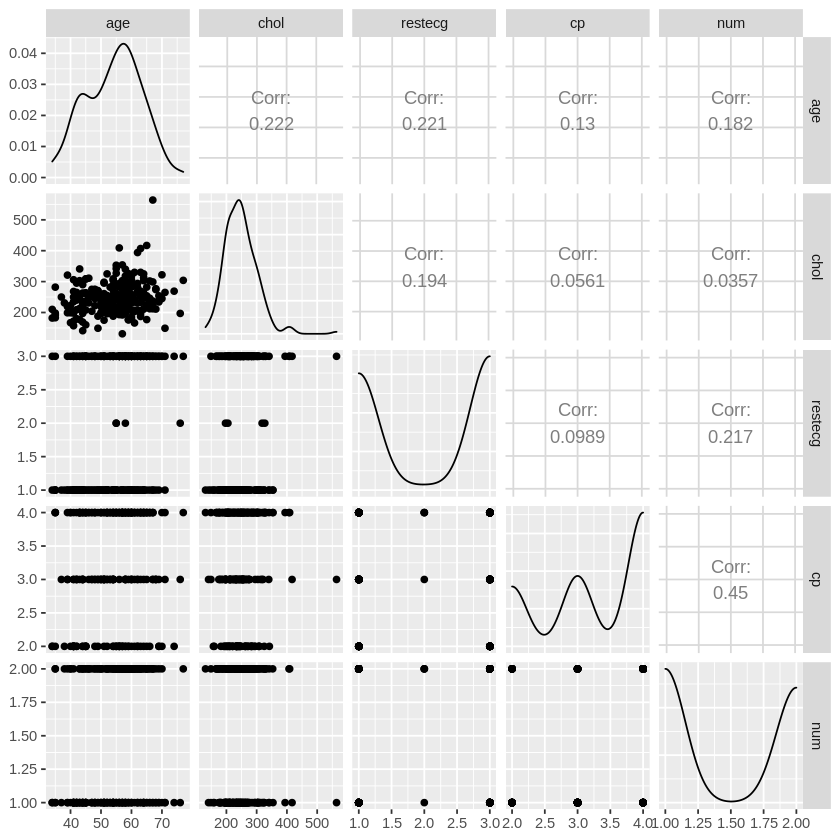

In [2]:
# Code part 2, Visualizing, Summarize data before analyzing.
# This is how we choose predictors
#[Note: some code copyed from proposal.]
count_num <- group_by(heart_data_train) %>%
            summarize(count = n()) %>%
            pull()
print("Read Attribute Information for more info about column names")
print(paste("Total observations:", count_num))

# Note: Need numeric var for cor()
heart_data_train2 <- heart_data_train %>%
    map(as.numeric) %>%
    as_tibble()

print("Correlation: ")
cor(heart_data_train2)
ggpairs(heart_data_train2)
print("Although the relationship between num and age, restecg, chol looks low, some articles suggested there are relationship between them.")

#[Note: some article I found (not peer reviewed)
#https://www.ncbi.nlm.nih.gov/books/NBK367910/
#https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800]
#[Note: add more information about how we choose predictors.]



In [3]:
#Code part 3, Classification, tuning

heart_recipe <- recipe(num ~ ., data = heart_data_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

heart_vfold <- vfold_cv(heart_data_train, v = 5, strata = num)
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = heart_vfold, grid = gridvals) %>%
  collect_metrics()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.7424682,5,0.02320724,Model19
20,accuracy,binary,0.7424682,5,0.02320724,Model20
25,accuracy,binary,0.7383136,5,0.03341834,Model25
26,accuracy,binary,0.7383136,5,0.03341834,Model26
21,accuracy,binary,0.7380237,5,0.03349386,Model21
22,accuracy,binary,0.7380237,5,0.03349386,Model22


[1] "Best k value: 19"


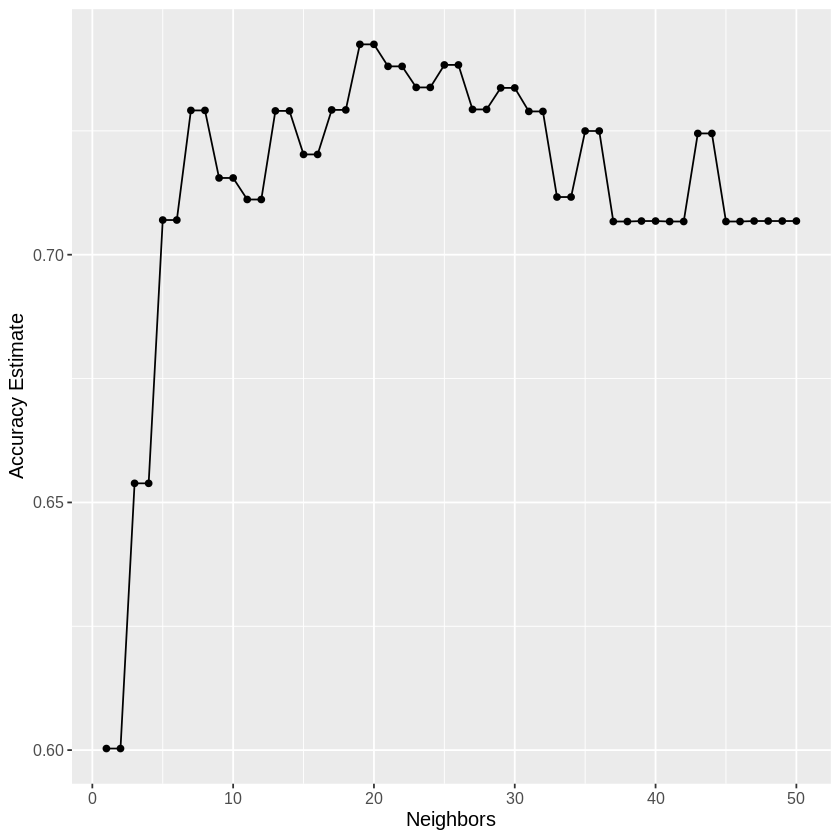

In [4]:
# Code part 4, analysis result from tuning

accuracies <- knn_results %>%
  filter(.metric == "accuracy") %>% 
  arrange(desc(mean))
head(accuracies , 6)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k
best_k <- slice(accuracies, 1) %>% 
  select(neighbors) %>% 
  pull()

print(paste("Best k value:", best_k))

In [5]:
# Code part 5, use best_k to fit

knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
  set_engine("kknn") %>%
  set_mode("classification")

heart_fit <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(knn_spec2) %>%
  fit(heart_data_train)

heart_predict <- predict(heart_fit, heart_data_test) %>%
  bind_cols(heart_data_test) 

heart_predict_accuracy <- heart_predict%>%
  metrics(truth = num, estimate = .pred_class) %>%
  filter(.metric == "accuracy") %>%
  select(.estimate) %>%
  pull()

confusion <- heart_predict %>%
             conf_mat(truth = num, estimate = .pred_class)

print(paste("Predict Accuracy:", heart_predict_accuracy))
print("confusion: ")
confusion


[1] "Predict Accuracy: 0.72972972972973"
[1] "confusion: "


          Truth
Prediction  0  1
         0 33 13
         1  7 21

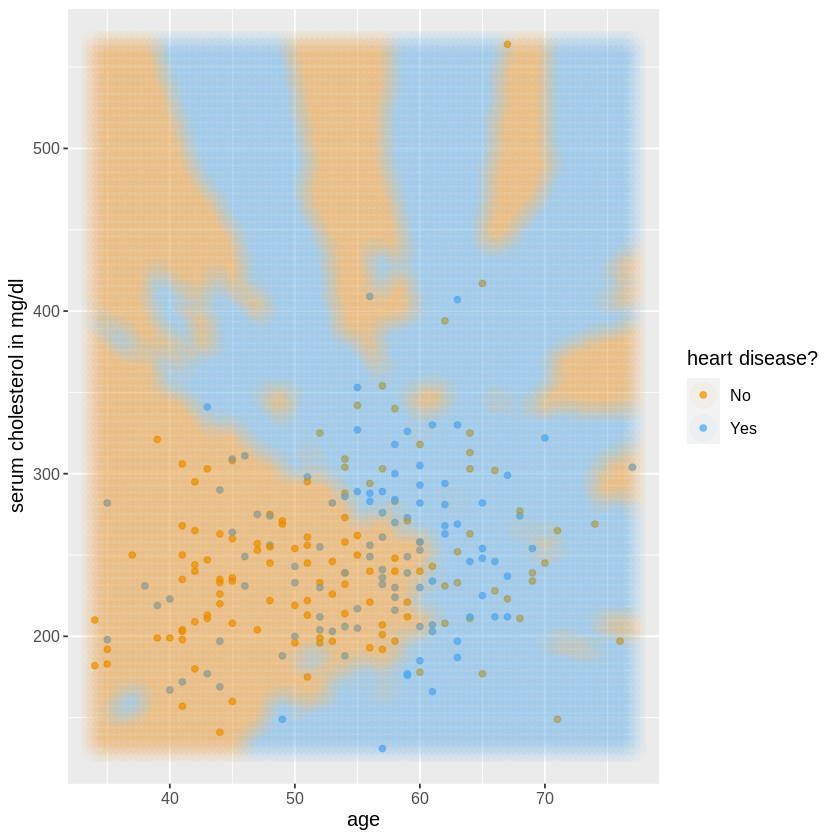

In [6]:
# Code part 6, result visualizing
# Note: some code copyed from textbook 5.8
size <- 100
x_grid <- seq(min(heart_data_train$age), 
                max(heart_data_train$age), 
                length.out = size)
y_grid <- seq(min(heart_data_train$chol), 
                max(heart_data_train$chol), 
                length.out = size)

restecg_mean <- heart_data_train %>% summarise(mean(restecg)) %>% pull()
cp_mean <- heart_data_train %>% summarise(mean(cp)) %>% pull()

asgrid <- as_tibble(expand.grid(age = x_grid, 
                                chol = y_grid,
                               restecg = restecg_mean,
                               cp = cp_mean))

knnPredGrid <- predict(heart_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(num = .pred_class)


wkflw_plot <- ggplot() +
  geom_point(data = heart_data_train, 
             mapping = aes(x = age, 
                           y = chol, 
                           color = num), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = age, 
                           y = chol, 
                           color = num), 
             alpha = 0.03, 
             size = 7) +
  labs(color = "heart disease?", 
       x = "age", 
       y = "serum cholesterol in mg/dl") +
  scale_color_manual(labels = c("No", "Yes"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot